In [1]:
import os
import sys
from optparse import OptionParser

import numpy as np
import scipy as ci 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import pandas as pd 

%matplotlib inline 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables 
import pickle
import warnings
from sklearn.externals import joblib
warnings.filterwarnings('once')

In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [3]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/bg-1-'

# Check pulses

In [11]:
f = tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_icetop_h5/corsika_icetop_12631.h5','r')
d_H = f.root.IT_veto_vector_closest_approach_distance_HLC.cols.item[:]
t_H = f.root.IT_veto_vector_delta_t_HLC.cols.item[:]
d_S = f.root.IT_veto_vector_closest_approach_distance_SLC.cols.item[:]
t_S = f.root.IT_veto_vector_delta_t_SLC.cols.item[:]
d = np.concatenate((d_H,d_S))
t = np.concatenate((t_H,t_S))
# f.root.IT_veto_
coincidence = f.root.MCPrimary_coincident.cols.value[:]

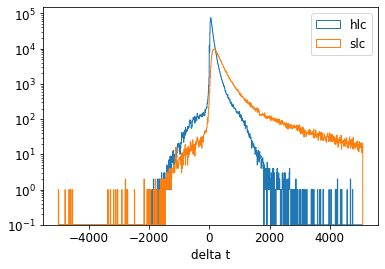

In [8]:
plt.hist(t_H,bins=np.arange(-5000,5100,10),histtype='step',log=True,label='hlc')
plt.hist(t_S,bins=np.arange(-5000,5100,10),histtype='step',log=True,label='slc')

# plt.ylim(10**3,10**8)
plt.xlabel('delta t')
plt.legend()
plt.show()

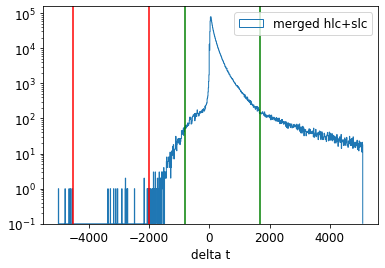

In [5]:
plt.hist(t,bins=np.arange(-5000,5100,10),histtype='step',log=True,label='merged hlc+slc')

plt.axvline(-800,color='g')
plt.axvline(1700,color='g')
plt.axvline(-4500,color='r')
plt.axvline(-2000,color='r')

# plt.ylim(10**3,10**8)
plt.xlabel('delta t')
plt.legend()
plt.show()

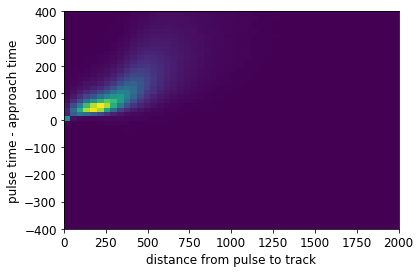

In [11]:
plt.hist2d(d,t,bins=[50,50],range=[[0,2000],[-400,400]])
plt.ylim(-400,400)
plt.xlabel('distance from pulse to track')
plt.ylabel('pulse time - approach time')
plt.show()

# After Preselection

In [13]:
lifetime = 86400*365

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_icetop_h5/corsika_icetop_12360.h5','r') as f:
    n_file = 20000     # non-zero 
    
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 6
    CUT = CUT_dedx 
    
    chi2_red_corsika_H = f.root.Collection.cols.chi2_red[:][CUT]
    zenith_corsika_H = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika_H = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    NPE_corsika_H = f.root.QTot.cols.value[:][CUT]
    len_dedx_corsika_H = f.root.Collection.cols.len_dEdxVector[:][CUT]

    passed_2_corsika_H = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    vetoed_2_corsika_H = (1-f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # events rejected 

    weight_corsika_H = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file 

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_icetop_h5/corsika_icetop_12630.h5','r') as f:
    n_file = 20000
    
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 6
    CUT = CUT_dedx 

    chi2_red_corsika_He = f.root.Collection.cols.chi2_red[:][CUT]
    zenith_corsika_He = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika_He = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    NPE_corsika_He = f.root.QTot.cols.value[:][CUT]
    len_dedx_corsika_He = f.root.Collection.cols.len_dEdxVector[:][CUT]
    
    passed_2_corsika_He = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    vetoed_2_corsika_He = (1-f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # events rejected 

    weight_corsika_He = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file 
    
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_icetop_h5/corsika_icetop_12362.h5','r') as f:
    n_file = 20000     # non-zero 
    
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 6
    CUT = CUT_dedx 

    chi2_red_corsika_Fe = f.root.Collection.cols.chi2_red[:][CUT]
    zenith_corsika_Fe = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika_Fe = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    NPE_corsika_Fe = f.root.QTot.cols.value[:][CUT]
    len_dedx_corsika_Fe = f.root.Collection.cols.len_dEdxVector[:][CUT]

    passed_2_corsika_Fe = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    vetoed_2_corsika_Fe = (1-f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # events rejected 

    weight_corsika_Fe = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file 
    

In [14]:
# veto efficiency
print('H:',np.sum(weight_corsika_H[vetoed_2_corsika_H])/np.sum(weight_corsika_H))
print('He:',np.sum(weight_corsika_He[vetoed_2_corsika_He])/np.sum(weight_corsika_He))
print('Fe:',np.sum(weight_corsika_Fe[vetoed_2_corsika_Fe])/np.sum(weight_corsika_Fe))

H: 0.9322401264306038
He: 0.8967457529603682
Fe: 0.923017150464354


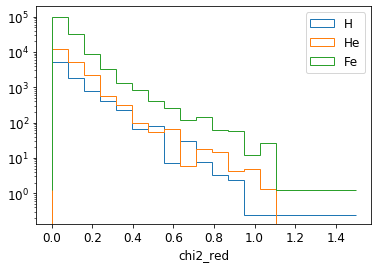

In [15]:
plt.figure()
plt.hist(chi2_red_corsika_H,bins=np.linspace(0,1.5,20),histtype='step',weights=weight_corsika_H,log=True,label='H')
plt.hist(chi2_red_corsika_He,bins=np.linspace(0,1.5,20),histtype='step',weights=weight_corsika_He,log=True,label='He')
plt.hist(chi2_red_corsika_Fe,bins=np.linspace(0,1.5,20),histtype='step',weights=weight_corsika_Fe,log=True,label='Fe')
plt.xlabel('chi2_red')
plt.legend()
plt.show()

# IT Eff Region

In [10]:
# ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model(dist,E): # E: log10 of energy!!! 

    a = params[0] + params[2] * (E + params[1])**2
    b = params[3] + params[5] * (E + params[4])**2
    val = 10 * a / dist**(1/3.) * np.exp( -10**6 * b / dist**2)
    
    val[val < 0.001] = 0.001 # This is arbitrary! 

    # low stat cut 
    val[E > 5.4+1.9*np.sqrt(1 - (dist)**2/2300**2)]=0.5
    val[dist>2200]=0.5
    return val

In [11]:
lifetime = 86400*365
IT_ineff_cut = 0.01 

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_icetop_h5/corsika_icetop_12360.h5','r') as f:
    n_file = 20000     # non-zero 
    
    ineff_ = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_ < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT = CUT_ineff & CUT_dedx 
    
    chi2_red_corsika_H = f.root.Collection.cols.chi2_red[:][CUT]
    POM_corsika_H = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_corsika_H = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika_H = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    NPE_corsika_H = f.root.QTot.cols.value[:][CUT]
    len_dedx_corsika_H = f.root.Collection.cols.len_dEdxVector[:][CUT]
    bsize_H = f.root.Bundle.cols.Size[:][CUT]
    passed_2_corsika_H = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    vetoed_2_corsika_H = (1-f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # events rejected 

    weight_corsika_H = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file 

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_icetop_h5/corsika_icetop_12630.h5','r') as f:
    n_file = 19999
    
    ineff_ = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_ < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT = CUT_ineff & CUT_dedx  

    chi2_red_corsika_He = f.root.Collection.cols.chi2_red[:][CUT]
    POM_corsika_He = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_corsika_He = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika_He = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    NPE_corsika_He = f.root.QTot.cols.value[:][CUT]
    len_dedx_corsika_He = f.root.Collection.cols.len_dEdxVector[:][CUT]
    bsize_He = f.root.Bundle.cols.Size[:][CUT]

    passed_2_corsika_He = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    vetoed_2_corsika_He = (1-f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # events rejected 

    weight_corsika_He = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file 
    
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_icetop_h5/corsika_icetop_12362.h5','r') as f:
    n_file = 20000     # non-zero 
    
    ineff_ = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_ < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT = CUT_ineff & CUT_dedx 

    chi2_red_corsika_Fe = f.root.Collection.cols.chi2_red[:][CUT]
    POM_corsika_Fe = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_corsika_Fe = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika_Fe = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    NPE_corsika_Fe = f.root.QTot.cols.value[:][CUT]
    len_dedx_corsika_Fe = f.root.Collection.cols.len_dEdxVector[:][CUT]
    bsize_Fe = f.root.Bundle.cols.Size[:][CUT]

    passed_2_corsika_Fe = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    vetoed_2_corsika_Fe = (1-f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # events rejected 

    weight_corsika_Fe = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file 
    

In [12]:
# veto efficiency
print('H:',np.sum(weight_corsika_H[vetoed_2_corsika_H])/np.sum(weight_corsika_H))
print('He:',np.sum(weight_corsika_He[vetoed_2_corsika_He])/np.sum(weight_corsika_He))
print('Fe:',np.sum(weight_corsika_Fe[vetoed_2_corsika_Fe])/np.sum(weight_corsika_Fe))

H: 0.9855207456079125
He: 0.9781793057181055
Fe: 0.996686118651863


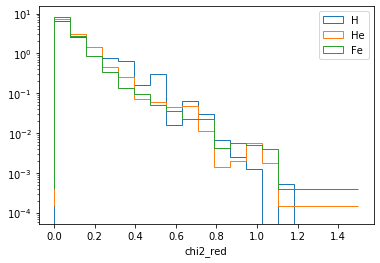

In [13]:
plt.figure()
plt.hist(chi2_red_corsika_H,bins=np.linspace(0,1.5,20),histtype='step',density=True,weights=weight_corsika_H,log=True,label='H')
plt.hist(chi2_red_corsika_He,bins=np.linspace(0,1.5,20),histtype='step',density=True,weights=weight_corsika_He,log=True,label='He')
plt.hist(chi2_red_corsika_Fe,bins=np.linspace(0,1.5,20),histtype='step',density=True,weights=weight_corsika_Fe,log=True,label='Fe')
plt.xlabel('chi2_red')
plt.legend()
plt.savefig(fig_dir + 'hist1d_chi2_each_element.png',dpi=300,bbox_inches='tight')
plt.show()

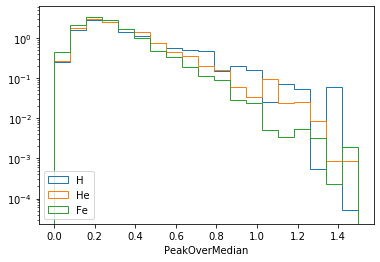

In [14]:
plt.figure()
plt.hist(np.log10(POM_corsika_H),bins=np.linspace(0,1.5,20),histtype='step',density=True,weights=weight_corsika_H,log=True,label='H')
plt.hist(np.log10(POM_corsika_He),bins=np.linspace(0,1.5,20),histtype='step',density=True,weights=weight_corsika_He,log=True,label='He')
plt.hist(np.log10(POM_corsika_Fe),bins=np.linspace(0,1.5,20),histtype='step',density=True,weights=weight_corsika_Fe,log=True,label='Fe')
plt.xlabel('PeakOverMedian')
plt.legend()
plt.savefig(fig_dir + 'hist1d_pom_each_element.png',dpi=300,bbox_inches='tight')

plt.show()

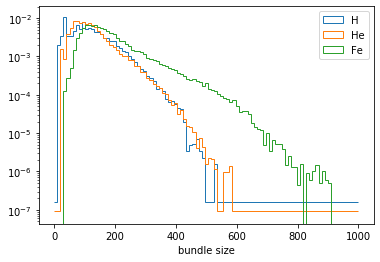

In [15]:
plt.figure()
plt.hist(bsize_H,bins=np.linspace(0,1000,100),histtype='step',density=True,weights=weight_corsika_H,log=True,label='H')
plt.hist(bsize_He,bins=np.linspace(0,1000,100),histtype='step',density=True,weights=weight_corsika_He,log=True,label='He')
plt.hist(bsize_Fe,bins=np.linspace(0,1000,100),histtype='step',density=True,weights=weight_corsika_Fe,log=True,label='Fe')
plt.xlabel('bundle size')
plt.legend()
plt.savefig(fig_dir + 'hist1d_bsize_each_element.png',dpi=300,bbox_inches='tight')

plt.show()

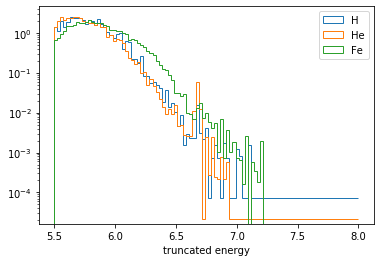

In [16]:
plt.figure()
plt.hist(np.log10(truncated_muon_e_corsika_H),bins=np.linspace(5.5,8,100),histtype='step',density=True,weights=weight_corsika_H,log=True,label='H')
plt.hist(np.log10(truncated_muon_e_corsika_He),bins=np.linspace(5.5,8,100),histtype='step',density=True,weights=weight_corsika_He,log=True,label='He')
plt.hist(np.log10(truncated_muon_e_corsika_Fe),bins=np.linspace(5.5,8,100),histtype='step',density=True,weights=weight_corsika_Fe,log=True,label='Fe')
plt.xlabel('truncated energy')
plt.legend()
plt.savefig(fig_dir + 'hist1d_truncated_each_element.png',dpi=300,bbox_inches='tight')

plt.show()

In [17]:
# Panel 
chi2_red_cut = 0.3
pom_cut = 0.7

df = pd.DataFrame({"": ["Low Stoch", "High Stoch"],
                   "IT vetoed": ["d11", "d21"],
                   "IT passed": ["d12", "d22"]})
df

,,IT vetoed,IT passed
0,Low Stoch,d11,d12
1,High Stoch,d21,d22


In [18]:
def err_ratio(x,y,x_err,y_err):
    return x/y*np.sqrt(  (x_err/x)**2 + (y_err/y)**2  )
def err_sum(x_err,y_err):
    return np.sqrt(x_err**2 + y_err**2)
def err_two_divide_one(x,y,t,x_err,y_err,t_err):
    return 1/t*np.sqrt(x_err**2+y_err**2+((x+y)/t)**2*t_err**2)
def err_two_divide_two(x,y,a,b,x_err,y_err,a_err,b_err):
    return np.sqrt((1/(a+b))**2*(x_err**2+y_err**2) + ((x+y)/(a+b)**2)**2*(a_err**2+b_err**2))

In [19]:
# store results: 

veto_ratio = []
err_veto_ratio = []

In [20]:
CUT_stoch_sig_IT_sig = (chi2_red_corsika_H > chi2_red_cut)&(np.log10(POM_corsika_H) > pom_cut) & passed_2_corsika_H
CUT_stoch_sig_IT_bg = (chi2_red_corsika_H > chi2_red_cut)&(np.log10(POM_corsika_H) > pom_cut) & vetoed_2_corsika_H
CUT_stoch_bg_IT_sig = np.any([chi2_red_corsika_H < chi2_red_cut, np.log10(POM_corsika_H) < pom_cut],axis=0) & passed_2_corsika_H
CUT_stoch_bg_IT_bg = np.any([chi2_red_corsika_H < chi2_red_cut, np.log10(POM_corsika_H) < pom_cut],axis=0) & vetoed_2_corsika_H

d11 = np.sum(weight_corsika_H[CUT_stoch_bg_IT_bg])
d12 = np.sum(weight_corsika_H[CUT_stoch_bg_IT_sig])
d21 = np.sum(weight_corsika_H[CUT_stoch_sig_IT_bg])
d22 = np.sum(weight_corsika_H[CUT_stoch_sig_IT_sig])
total = np.sum([d11,d12,d21,d22])

d11_len, d12_len, d21_len, d22_len = len(weight_corsika_H[CUT_stoch_bg_IT_bg]),len(weight_corsika_H[CUT_stoch_bg_IT_sig]),len(weight_corsika_H[CUT_stoch_sig_IT_bg]),len(weight_corsika_H[CUT_stoch_sig_IT_sig])

d11_err = np.sqrt(np.sum(weight_corsika_H[CUT_stoch_bg_IT_bg]**2))
d12_err = np.sqrt(np.sum(weight_corsika_H[CUT_stoch_bg_IT_sig]**2))
d21_err = np.sqrt(np.sum(weight_corsika_H[CUT_stoch_sig_IT_bg]**2))
d22_err = np.sqrt(np.sum(weight_corsika_H[CUT_stoch_sig_IT_sig]**2))
total_err = np.sqrt(d11_err**2 + d12_err**2 + d21_err**2 + d22_err**2)

df_H = pd.DataFrame({"Element: H": ["Low Stoch", "High Stoch", "Sum"],
                        "IT vetoed": [r'%.3f$\pm$%.3f'%(d11/total, err_ratio(d11,total,d11_err,total_err)),
                                      r'%.3f$\pm$%.3f'%(d21/total, err_ratio(d21,total,d21_err,total_err)),
                                      r'%.3f$\pm$%.3f'%((d11+d21)/total, err_two_divide_one(d11,d21,total,d11_err,d21_err,total_err))],
                        
                        "IT passed": [r'%.3f$\pm$%.3f'%(d12/total, err_ratio(d12,total,d12_err,total_err)),
                                      r'%.3f$\pm$%.3f'%(d22/total, err_ratio(d22,total,d22_err,total_err)),
                                      r'%.3f$\pm$%.3f'%((d12+d22)/total, err_two_divide_one(d12,d22,total,d12_err,d22_err,total_err))  ],
                        
                        "Sum":       [r'%.3f$\pm$%.3f'%((d11+d12)/total, err_two_divide_one(d11,d12,total,d11_err,d12_err,total_err)), 
                                      r'%.3f$\pm$%.3f'%((d21+d22)/total, err_two_divide_one(d21,d22,total,d21_err,d22_err,total_err)),
                                      1],
                        
                        "Passed/Vetoed": [r'%.3f$\pm$%.3f'%(d12/d11, err_ratio(d12,d11,d12_err,d11_err)),
                                          r'%.3f$\pm$%.3f'%(d22/d21, err_ratio(d22,d21,d22_err,d21_err)),
                                          r'%.3f$\pm$%.3f'%((d12+d22)/(d11+d21), err_two_divide_two(d12,d22,d11,d21,d12_err,d22_err,d11_err,d21_err) )   ]
                    })

df_H_unweighted = pd.DataFrame({"Unweighted H": ["Low Stoch", "High Stoch"],
                   "IT vetoed": [d11_len, d21_len],
                   "IT passed": [d12_len, d22_len]})

df_H_weighted = pd.DataFrame({"Weighted H": ["Low Stoch", "High Stoch"],
                   "IT vetoed": [d11, d21],
                   "IT passed": [d12, d22]})

veto_ratio.append((d12+d22)/(d11+d21))
err_veto_ratio.append(err_two_divide_two(d12,d22,d11,d21,d12_err,d22_err,d11_err,d21_err))

# print('total weight of H:',np.sum(weight_corsika_H))
print(df_H_unweighted)
print(df_H_weighted)
df_H

  Unweighted H  IT vetoed  IT passed
0    Low Stoch       8657          6
1   High Stoch         43          2
   Weighted H    IT vetoed  IT passed
0   Low Stoch  5418.577519  51.241958
1  High Stoch   273.376321  32.384133


,Element: H,IT vetoed,IT passed,Sum,Passed/Vetoed
0,Low Stoch,0.938$\pm$0.046,0.009$\pm$0.006,0.947$\pm$0.047,0.009$\pm$0.006
1,High Stoch,0.047$\pm$0.013,0.006$\pm$0.004,0.053$\pm$0.014,0.118$\pm$0.098
2,Sum,0.986$\pm$0.049,0.014$\pm$0.007,1,0.015$\pm$0.007


In [21]:
CUT_stoch_sig_IT_sig = (chi2_red_corsika_He > chi2_red_cut)&(np.log10(POM_corsika_He) > pom_cut) & passed_2_corsika_He
CUT_stoch_sig_IT_bg = (chi2_red_corsika_He > chi2_red_cut)&(np.log10(POM_corsika_He) > pom_cut) & vetoed_2_corsika_He
CUT_stoch_bg_IT_sig = np.any([chi2_red_corsika_He < chi2_red_cut, np.log10(POM_corsika_He) < pom_cut],axis=0) & passed_2_corsika_He
CUT_stoch_bg_IT_bg = np.any([chi2_red_corsika_He < chi2_red_cut, np.log10(POM_corsika_He) < pom_cut],axis=0) & vetoed_2_corsika_He

d11 = np.sum(weight_corsika_He[CUT_stoch_bg_IT_bg])
d12 = np.sum(weight_corsika_He[CUT_stoch_bg_IT_sig])
d21 = np.sum(weight_corsika_He[CUT_stoch_sig_IT_bg])
d22 = np.sum(weight_corsika_He[CUT_stoch_sig_IT_sig])
total = np.sum([d11,d12,d21,d22])

d11_len, d12_len, d21_len, d22_len = len(weight_corsika_He[CUT_stoch_bg_IT_bg]),len(weight_corsika_He[CUT_stoch_bg_IT_sig]),len(weight_corsika_He[CUT_stoch_sig_IT_bg]),len(weight_corsika_He[CUT_stoch_sig_IT_sig])

d11_err = np.sqrt(np.sum(weight_corsika_He[CUT_stoch_bg_IT_bg]**2))
d12_err = np.sqrt(np.sum(weight_corsika_He[CUT_stoch_bg_IT_sig]**2))
d21_err = np.sqrt(np.sum(weight_corsika_He[CUT_stoch_sig_IT_bg]**2))
d22_err = np.sqrt(np.sum(weight_corsika_He[CUT_stoch_sig_IT_sig]**2))
total_err = np.sqrt(d11_err**2 + d12_err**2 + d21_err**2 + d22_err**2)

df_He = pd.DataFrame({"Element: He": ["Low Stoch", "High Stoch", "Sum"],
                        "IT vetoed": [r'%.3f$\pm$%.3f'%(d11/total, err_ratio(d11,total,d11_err,total_err)),
                                      r'%.3f$\pm$%.3f'%(d21/total, err_ratio(d21,total,d21_err,total_err)),
                                      r'%.3f$\pm$%.3f'%((d11+d21)/total, err_two_divide_one(d11,d21,total,d11_err,d21_err,total_err))],
                        
                        "IT passed": [r'%.3f$\pm$%.3f'%(d12/total, err_ratio(d12,total,d12_err,total_err)),
                                      r'%.3f$\pm$%.3f'%(d22/total, err_ratio(d22,total,d22_err,total_err)),
                                      r'%.3f$\pm$%.3f'%((d12+d22)/total, err_two_divide_one(d12,d22,total,d12_err,d22_err,total_err))  ],
                        
                        "Sum":       [r'%.3f$\pm$%.3f'%((d11+d12)/total, err_two_divide_one(d11,d12,total,d11_err,d12_err,total_err)), 
                                      r'%.3f$\pm$%.3f'%((d21+d22)/total, err_two_divide_one(d21,d22,total,d21_err,d22_err,total_err)),
                                      1],
                        
                        "Passed/Vetoed": [r'%.3f$\pm$%.3f'%(d12/d11, err_ratio(d12,d11,d12_err,d11_err)),
                                          r'%.3f$\pm$%.3f'%(d22/d21, err_ratio(d22,d21,d22_err,d21_err)),
                                          r'%.3f$\pm$%.3f'%((d12+d22)/(d11+d21), err_two_divide_two(d12,d22,d11,d21,d12_err,d22_err,d11_err,d21_err) )   ]
                    })

df_He_unweighted = pd.DataFrame({"Unweighted He": ["Low Stoch", "High Stoch"],
                   "IT vetoed": [d11_len, d21_len],
                   "IT passed": [d12_len, d22_len]})

df_He_weighted = pd.DataFrame({"Weighted He": ["Low Stoch", "High Stoch"],
                   "IT vetoed": [d11, d21],
                   "IT passed": [d12, d22]})

veto_ratio.append((d12+d22)/(d11+d21))
err_veto_ratio.append(err_two_divide_two(d12,d22,d11,d21,d12_err,d22_err,d11_err,d21_err))

# print('total weight of He:',np.sum(weight_corsika_He))
print(df_He_unweighted)
print(df_He_weighted)

  Unweighted He  IT vetoed  IT passed
0     Low Stoch      12232          2
1    High Stoch         61          1
  Weighted He     IT vetoed   IT passed
0   Low Stoch  12646.144401  270.206283
1  High Stoch    258.980923   17.674265


In [22]:
CUT_stoch_sig_IT_sig = (chi2_red_corsika_Fe > chi2_red_cut)&(np.log10(POM_corsika_Fe) > pom_cut) & passed_2_corsika_Fe
CUT_stoch_sig_IT_bg = (chi2_red_corsika_Fe > chi2_red_cut)&(np.log10(POM_corsika_Fe) > pom_cut) & vetoed_2_corsika_Fe
CUT_stoch_bg_IT_sig = np.any([chi2_red_corsika_Fe < chi2_red_cut, np.log10(POM_corsika_Fe) < pom_cut],axis=0) & passed_2_corsika_Fe
CUT_stoch_bg_IT_bg = np.any([chi2_red_corsika_Fe < chi2_red_cut, np.log10(POM_corsika_Fe) < pom_cut],axis=0) & vetoed_2_corsika_Fe

d11 = np.sum(weight_corsika_Fe[CUT_stoch_bg_IT_bg])
d12 = np.sum(weight_corsika_Fe[CUT_stoch_bg_IT_sig])
d21 = np.sum(weight_corsika_Fe[CUT_stoch_sig_IT_bg])
d22 = np.sum(weight_corsika_Fe[CUT_stoch_sig_IT_sig])
total = np.sum([d11,d12,d21,d22])

d11_len, d12_len, d21_len, d22_len = len(weight_corsika_Fe[CUT_stoch_bg_IT_bg]),len(weight_corsika_Fe[CUT_stoch_bg_IT_sig]),len(weight_corsika_Fe[CUT_stoch_sig_IT_bg]),len(weight_corsika_Fe[CUT_stoch_sig_IT_sig])

d11_err = np.sqrt(np.sum(weight_corsika_Fe[CUT_stoch_bg_IT_bg]**2))
d12_err = np.sqrt(np.sum(weight_corsika_Fe[CUT_stoch_bg_IT_sig]**2))
d21_err = np.sqrt(np.sum(weight_corsika_Fe[CUT_stoch_sig_IT_bg]**2))
d22_err = np.sqrt(np.sum(weight_corsika_Fe[CUT_stoch_sig_IT_sig]**2))
total_err = np.sqrt(d11_err**2 + d12_err**2 + d21_err**2 + d22_err**2)

df_Fe = pd.DataFrame({"Element: Fe": ["Low Stoch", "High Stoch", "Sum"],
                        "IT vetoed": [r'%.3f$\pm$%.3f'%(d11/total, err_ratio(d11,total,d11_err,total_err)),
                                      r'%.3f$\pm$%.3f'%(d21/total, err_ratio(d21,total,d21_err,total_err)),
                                      r'%.3f$\pm$%.3f'%((d11+d21)/total, err_two_divide_one(d11,d21,total,d11_err,d21_err,total_err))],
                        
                        "IT passed": [r'%.3f$\pm$%.3f'%(d12/total, err_ratio(d12,total,d12_err,total_err)),
                                      r'%.3f$\pm$%.3f'%(d22/total, err_ratio(d22,total,d22_err,total_err)),
                                      r'%.3f$\pm$%.3f'%((d12+d22)/total, err_two_divide_one(d12,d22,total,d12_err,d22_err,total_err))  ],
                        
                        "Sum":       [r'%.3f$\pm$%.3f'%((d11+d12)/total, err_two_divide_one(d11,d12,total,d11_err,d12_err,total_err)), 
                                      r'%.3f$\pm$%.3f'%((d21+d22)/total, err_two_divide_one(d21,d22,total,d21_err,d22_err,total_err)),
                                      1],
                        
                        "Passed/Vetoed": [r'%.3f$\pm$%.3f'%(d12/d11, err_ratio(d12,d11,d12_err,d11_err)),
                                          r'%.3f$\pm$%.3f'%(d22/d21, err_ratio(d22,d21,d22_err,d21_err)),
                                          r'%.3f$\pm$%.3f'%((d12+d22)/(d11+d21), err_two_divide_two(d12,d22,d11,d21,d12_err,d22_err,d11_err,d21_err) )   ]
                    })

df_Fe_unweighted = pd.DataFrame({"Unweighted Fe": ["Low Stoch", "High Stoch"],
                   "IT vetoed": [d11_len, d21_len],
                   "IT passed": [d12_len, d22_len]})

df_Fe_weighted = pd.DataFrame({"Weighted Fe": ["Low Stoch", "High Stoch"],
                   "IT vetoed": [d11, d21],
                   "IT passed": [d12, d22]})

veto_ratio.append((d12+d22)/(d11+d21))
err_veto_ratio.append(err_two_divide_two(d12,d22,d11,d21,d12_err,d22_err,d11_err,d21_err))

# print('total weight of Fe:',np.sum(weight_corsika_Fe))
# print(df_Fe_unweighted)
# print(df_Fe_weighted)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [23]:
print(df_H_unweighted)
df_H

  Unweighted H  IT vetoed  IT passed
0    Low Stoch       8657          6
1   High Stoch         43          2


,Element: H,IT vetoed,IT passed,Sum,Passed/Vetoed
0,Low Stoch,0.938$\pm$0.046,0.009$\pm$0.006,0.947$\pm$0.047,0.009$\pm$0.006
1,High Stoch,0.047$\pm$0.013,0.006$\pm$0.004,0.053$\pm$0.014,0.118$\pm$0.098
2,Sum,0.986$\pm$0.049,0.014$\pm$0.007,1,0.015$\pm$0.007


In [24]:
print(df_He_unweighted)
df_He

  Unweighted He  IT vetoed  IT passed
0     Low Stoch      12232          2
1    High Stoch         61          1


,Element: He,IT vetoed,IT passed,Sum,Passed/Vetoed
0,Low Stoch,0.959$\pm$0.041,0.020$\pm$0.020,0.979$\pm$0.046,0.021$\pm$0.021
1,High Stoch,0.020$\pm$0.005,0.001$\pm$0.001,0.021$\pm$0.005,0.068$\pm$0.071
2,Sum,0.978$\pm$0.042,0.022$\pm$0.021,1,0.022$\pm$0.021


In [25]:
print(df_Fe_unweighted)
df_Fe

  Unweighted Fe  IT vetoed  IT passed
0     Low Stoch      22174         31
1    High Stoch        144          0


,Element: Fe,IT vetoed,IT passed,Sum,Passed/Vetoed
0,Low Stoch,0.988$\pm$0.015,0.003$\pm$0.001,0.991$\pm$0.015,0.003$\pm$0.001
1,High Stoch,0.009$\pm$0.001,0.000$\pm$nan,0.009$\pm$0.001,0.000$\pm$nan
2,Sum,0.997$\pm$0.015,0.003$\pm$0.001,1,0.003$\pm$0.001


[-0.00373303  0.01931288]


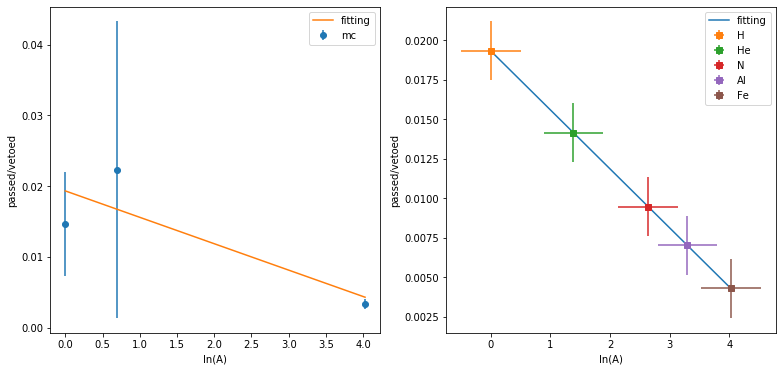

In [26]:
# systematics: 
plt.figure(figsize=(13,6))
A = np.array([1,2,56])
plt.subplot(121)
plt.errorbar(np.log(A),veto_ratio,yerr=err_veto_ratio,fmt='o',label='mc')

# fitting
def linear(x,k,b):
    return k*x + b
popt, pcov = curve_fit(linear, np.log(A), veto_ratio)
print(popt)
slope = (linear(4,*popt)-linear(1,*popt))/(4-1)
plt.plot(np.log(A),linear(np.log(A),*popt),label='fitting')
plt.legend()
plt.xlabel('ln(A)')
plt.ylabel('passed/vetoed')

e_size = 0.5
# plt.fill_between(np.log(A),linear(np.log(A),*popt)+slope*e_size,linear(np.log(A),*popt)-slope*e_size,color='y',alpha=0.5)

plt.subplot(122)
plt.plot(np.log(A),linear(np.log(A),*popt),label='fitting')
a = np.array([1,4,14,27,56])
ele = ['H','He','N','Al','Fe']
for i in range(0,len(a)):
    plt.errorbar(np.log(a[i]),linear(np.log(a[i]),*popt),fmt='s',xerr=[[e_size],[e_size]],
                 yerr=[[linear(np.log(a[i])-e_size,*popt)-linear(np.log(a[i]),*popt)],[linear(np.log(a[i]),*popt)-linear(np.log(a[i])+e_size,*popt)]],label=ele[i])

plt.legend()
plt.xlabel('ln(A)')
plt.ylabel('passed/vetoed')
plt.show()

In [27]:
for i in range(0,len(a)):
    print([[e_size],[e_size]])
    
    print([[linear(np.log(a[i])-e_size,*popt)-linear(np.log(a[i]),*popt)],[linear(np.log(a[i]),*popt)-linear(np.log(a[i])+e_size,*popt)]])


[[0.5], [0.5]]
[[0.0018665163676195619], [0.0018665163676195619]]
[[0.5], [0.5]]
[[0.0018665163676195619], [0.0018665163676195619]]
[[0.5], [0.5]]
[[0.0018665163676195619], [0.0018665163676195636]]
[[0.5], [0.5]]
[[0.0018665163676195636], [0.0018665163676195619]]
[[0.5], [0.5]]
[[0.0018665163676195619], [0.0018665163676195636]]


# Correlation between stoch and veto efficiency

# maybe try plot hist2d of chi2 and pom, bin content is eff

In [62]:
lifetime = 86400*365
IT_ineff_cut = 0.01 

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_icetop_h5/corsika_icetop_12360.h5','r') as f:
    n_file = 20000     # non-zero 
    
    ineff_ = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_ < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT = CUT_ineff & CUT_dedx 
    
    chi2_red_corsika_H = f.root.Collection.cols.chi2_red[:][CUT]
    POM_corsika_H = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_corsika_H = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika_H = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    NPE_corsika_H = f.root.QTot.cols.value[:][CUT]
    len_dedx_corsika_H = f.root.Collection.cols.len_dEdxVector[:][CUT]

    passed_2_corsika_H = (f.root.IT_veto_double.cols.flag_window_5[:][CUT]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    vetoed_2_corsika_H = (1-f.root.IT_veto_double.cols.flag_window_5[:][CUT]).astype(bool) # events rejected 

    weight_corsika_H = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file 

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_icetop_h5/corsika_icetop_12630.h5','r') as f:
    n_file = 20000
    
    ineff_ = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_ < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT = CUT_ineff & CUT_dedx  

    chi2_red_corsika_He = f.root.Collection.cols.chi2_red[:][CUT]
    POM_corsika_He = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_corsika_He = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika_He = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    NPE_corsika_He = f.root.QTot.cols.value[:][CUT]
    len_dedx_corsika_He = f.root.Collection.cols.len_dEdxVector[:][CUT]
    
    passed_2_corsika_He = (f.root.IT_veto_double.cols.flag_window_5[:][CUT]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    vetoed_2_corsika_He = (1-f.root.IT_veto_double.cols.flag_window_5[:][CUT]).astype(bool) # events rejected 

    weight_corsika_He = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file 
    
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_icetop_h5/corsika_icetop_12362.h5','r') as f:
    n_file = 20000     # non-zero 
    
    ineff_ = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_ < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT = CUT_ineff & CUT_dedx 

    chi2_red_corsika_Fe = f.root.Collection.cols.chi2_red[:][CUT]
    POM_corsika_Fe = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_corsika_Fe = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika_Fe = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    NPE_corsika_Fe = f.root.QTot.cols.value[:][CUT]
    len_dedx_corsika_Fe = f.root.Collection.cols.len_dEdxVector[:][CUT]

    passed_2_corsika_Fe = (f.root.IT_veto_double.cols.flag_window_5[:][CUT]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    vetoed_2_corsika_Fe = (1-f.root.IT_veto_double.cols.flag_window_5[:][CUT]).astype(bool) # events rejected 

    weight_corsika_Fe = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file 
    

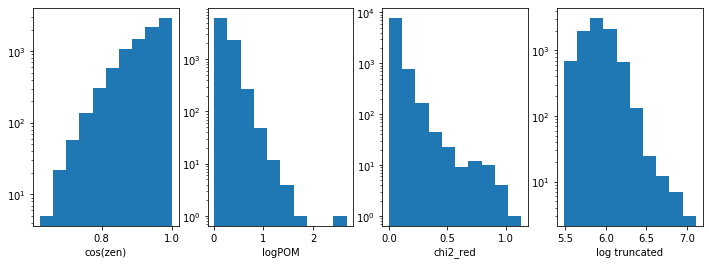

In [63]:
plt.figure(figsize=(12,4))
plt.subplot(141)
plt.hist(np.cos(zenith_corsika_H),log=True)
plt.xlabel('cos(zen)')
plt.subplot(142)
plt.hist(np.log10(POM_corsika_H),log=True)
plt.xlabel('logPOM')
plt.subplot(143)
plt.hist(chi2_red_corsika_H,log=True)
plt.xlabel('chi2_red')
plt.subplot(144)
plt.hist(np.log10(truncated_muon_e_corsika_H),log=True)
plt.xlabel('log truncated')
plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


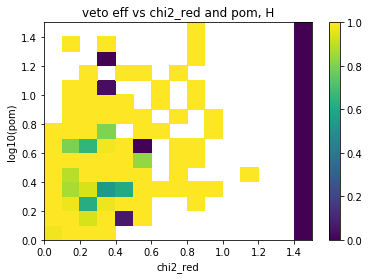

In [65]:
e_min = 0
e_max = 10
coszen_min = 0
coszen_max = 1

# e_min = 6
# e_max = 6.5
# coszen_min = 0.9
# coszen_max = 0.95 

cut_energy = (np.log10(truncated_muon_e_corsika_H)>e_min)&(np.log10(truncated_muon_e_corsika_H)<e_max)
cut_zenith = (np.cos(zenith_corsika_H)>coszen_min)&(np.cos(zenith_corsika_H)<coszen_max)

chi2_red_corsika_H = chi2_red_corsika_H[cut_energy&cut_zenith]
vetoed_2_corsika_H = vetoed_2_corsika_H[cut_energy&cut_zenith]
weight_corsika_H = weight_corsika_H[cut_energy&cut_zenith]

ratios = []
bins_chi2_red = []
bins_poms = []
xbin = np.arange(0,1.5,0.1)
ybin = np.arange(0,2,0.1)
for i in range(0,len(xbin)-1):
    for j in range(0,len(ybin)-1):
        bin_chi2_red = (chi2_red_corsika_H>xbin[i])&(chi2_red_corsika_H<xbin[i+1])
        bin_pom = (np.log10(POM_corsika_H)>ybin[j])&(np.log10(POM_corsika_H)<ybin[j+1])
        
        total = np.sum(weight_corsika_H[bin_chi2_red&bin_pom])
        vetoed = np.sum((weight_corsika_H[bin_chi2_red&bin_pom])[vetoed_2_corsika_H[bin_chi2_red&bin_pom]])
        ratio = vetoed/total 

        ratios.append(ratio)
        bins_chi2_red.append(xbin[i])
        bins_poms.append(ybin[j])

plt.figure()
plt.hist2d(bins_chi2_red,bins_poms,weights=ratios,range=[[0,1.5],[0,2]],bins=[len(xbin),len(ybin)])
plt.colorbar()
plt.xlim(0,1.5)
plt.ylim(0,1.5)
plt.xlabel('chi2_red')
plt.ylabel('log10(pom)')
plt.title('veto eff vs chi2_red and pom, H')
plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


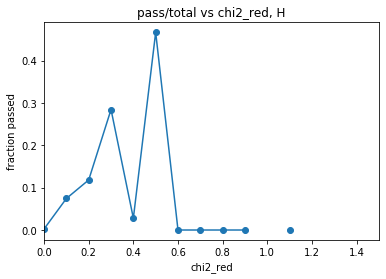

In [56]:
e_min = 0
e_max = 10
coszen_min = 0
coszen_max = 1

# e_min = 6
# e_max = 6.5
# coszen_min = 0.9
# coszen_max = 0.95 

cut_energy = (np.log10(truncated_muon_e_corsika_H)>e_min)&(np.log10(truncated_muon_e_corsika_H)<e_max)
cut_zenith = (np.cos(zenith_corsika_H)>coszen_min)&(np.cos(zenith_corsika_H)<coszen_max)

chi2_red_corsika_H = chi2_red_corsika_H[cut_energy&cut_zenith]
vetoed_2_corsika_H = vetoed_2_corsika_H[cut_energy&cut_zenith]
weight_corsika_H = weight_corsika_H[cut_energy&cut_zenith]

ratios = []
bins_chi2_red = []
mybins = np.arange(0,1.5,0.1)
for i in range(0,len(mybins)-1):
    bin_chi2_red = (chi2_red_corsika_H>=mybins[i])&(chi2_red_corsika_H<mybins[i+1])
    total = np.sum(weight_corsika_H[bin_chi2_red])

    passed = np.sum((weight_corsika_H[bin_chi2_red])[passed_2_corsika_H[bin_chi2_red]])
#     print(i,i+1,len(weight_corsika_H[bin_chi2_red]),len((weight_corsika_H[bin_chi2_red])[passed_2_corsika_H[bin_chi2_red]]))
    ratio = passed/total 
    
    ratios.append(ratio)
    bins_chi2_red.append(mybins[i])

plt.figure()
plt.plot(bins_chi2_red,ratios,'-o')
plt.xlim(0,1.5)
# plt.ylim(0.96,1.01)
plt.xlabel('chi2_red')
plt.ylabel('fraction passed')
plt.title('pass/total vs chi2_red, H')
plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


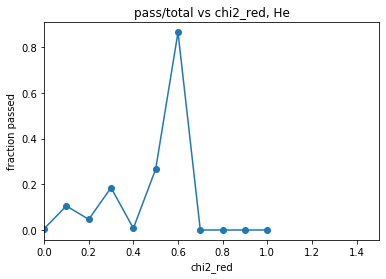

In [59]:
e_min = 0
e_max = 10
coszen_min = 0
coszen_max = 1

# e_min = 6
# e_max = 6.5
# coszen_min = 0.9
# coszen_max = 0.95 

cut_energy = (np.log10(truncated_muon_e_corsika_He)>e_min)&(np.log10(truncated_muon_e_corsika_He)<e_max)
cut_zenith = (np.cos(zenith_corsika_He)>coszen_min)&(np.cos(zenith_corsika_He)<coszen_max)

chi2_red_corsika_He = chi2_red_corsika_He[cut_energy&cut_zenith]
vetoed_2_corsika_He = vetoed_2_corsika_He[cut_energy&cut_zenith]
weight_corsika_He = weight_corsika_He[cut_energy&cut_zenith]

ratios = []
bins_chi2_red = []
mybins = np.arange(0,1.5,0.1)
for i in range(0,len(mybins)-1):
    bin_chi2_red = (chi2_red_corsika_He>=mybins[i])&(chi2_red_corsika_He<mybins[i+1])
    total = np.sum(weight_corsika_He[bin_chi2_red])

    passed = np.sum((weight_corsika_He[bin_chi2_red])[passed_2_corsika_He[bin_chi2_red]])
    ratio = passed/total 
    
    ratios.append(ratio)
    bins_chi2_red.append(mybins[i])

plt.figure()
plt.plot(bins_chi2_red,ratios,'-o')
plt.xlim(0,1.5)
# plt.ylim(0.96,1.01)
plt.xlabel('chi2_red')
plt.ylabel('fraction passed')
plt.title('pass/total vs chi2_red, He')
plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


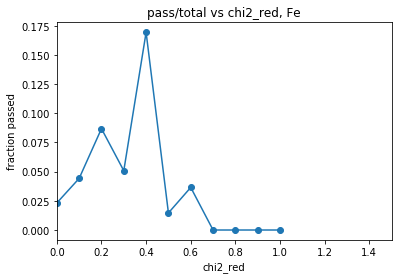

In [60]:
e_min = 0
e_max = 10
coszen_min = 0
coszen_max = 1

# e_min = 6
# e_max = 6.5
# coszen_min = 0.9
# coszen_max = 0.95 

cut_energy = (np.log10(truncated_muon_e_corsika_Fe)>e_min)&(np.log10(truncated_muon_e_corsika_Fe)<e_max)
cut_zenith = (np.cos(zenith_corsika_Fe)>coszen_min)&(np.cos(zenith_corsika_Fe)<coszen_max)

chi2_red_corsika_Fe = chi2_red_corsika_Fe[cut_energy&cut_zenith]
vetoed_2_corsika_Fe = vetoed_2_corsika_Fe[cut_energy&cut_zenith]
weight_corsika_Fe = weight_corsika_Fe[cut_energy&cut_zenith]

ratios = []
bins_chi2_red = []
mybins = np.arange(0,1.5,0.1)
for i in range(0,len(mybins)-1):
    bin_chi2_red = (chi2_red_corsika_Fe>=mybins[i])&(chi2_red_corsika_Fe<mybins[i+1])
    total = np.sum(weight_corsika_Fe[bin_chi2_red])

    passed = np.sum((weight_corsika_Fe[bin_chi2_red])[passed_2_corsika_Fe[bin_chi2_red]])
    ratio = passed/total 
    
    ratios.append(ratio)
    bins_chi2_red.append(mybins[i])

plt.figure()
plt.plot(bins_chi2_red,ratios,'-o')
plt.xlim(0,1.5)
# plt.ylim(0.96,1.01)
plt.xlabel('chi2_red')
plt.ylabel('fraction passed')
plt.title('pass/total vs chi2_red, Fe')
plt.show()